In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hybridRK45 import solve_ode

## General description

The `hybridRK45.py` provides a integration of both explict and implicit RK45 with adaptive step size algorithm to solve the system of ODEs. The main function `solve_ode` acts as a substitute to `solve_ivp` in SciPy.

The main funciton is `solve_ode(f,trange,y0,rtol=1e-3,atol=1e-6,method="explicit",R_threshold=1000,args=None)` with 8 inputs:

- `f`, a callable function $f(t,y,\textrm{\texttt{args}})$, which is the same as `solve_ivp`
- `trange`, a tuple $(t_0,t_{\rm max})$ that indicates the beginning and the end of time 
- `y0`, an 1D array that stores the initial condition
- `rtol` and `atol`, relative and absolute tolerances. See `solve_ivp` document for detail
-  `method`, string with `explicit`, `implicit` and `hybrid` that will be used to solve the ODEs. `hybrid` will force the solver to solve the problem between explicit and implicit methods judging by the stiffness ratio $R$.
-  `R_threshold`, threshold value for the solver to switch from explicit to implicit method
-  `args`, a tuple with n arguments that will be passed to the callable $f$ by `f(t,y,*args)`

and a tuple output:

- `(time_steps,solutions)`, `time_steps` is an 1D array of shape (n,) with each element corresponds to every time stamps and `solutions` is an array of shape (n,m) where m corresponds to the m-th ODE. If the system has only one ODE, then it has the same shape as `time_steps`

## Examples

### Chaotic system
A chaotic system can be described by Lorenz equations of the form
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-y \\
\frac{dz}{dt} &= xy - \beta x
\end{align}
where $\sigma$ is the Prandtl number, $\rho$ the Rayleigh number and $\beta$ the geometric factor. Given $(\sigma,\rho,\beta)=(10,40,8/3)$ and $(x_0,y_0,z_0)=(1,1,1)$, we solve the Lorenz equation within $0\leq t\leq 30$ by `solve_ode`.

In [4]:
# Define a chaotic system
def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Parameters
sigma = 10
rho = 40
beta = 8/3
args = (sigma,rho,beta)

# Initial conditions and evaluation period
initial_state = [1.0, 1.0, 1.0]
t_span = (0,30)

# Get solutions
sol_t,sol_state = solve_ode(lorenz,t_span,initial_state,rtol=1e-7,atol=1e-8,method='hybrid',args=args)

Progress: 100.00% and stiffness ratio R = 1.577e+00.

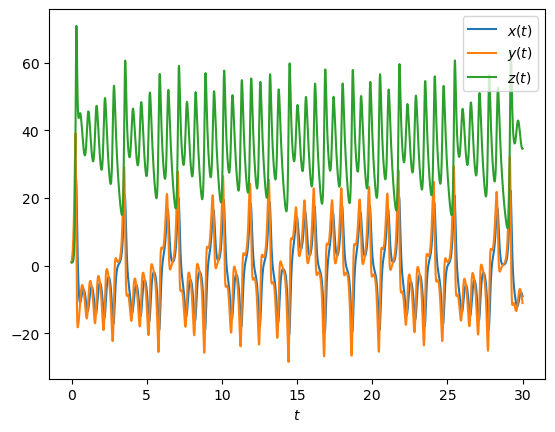

In [5]:
labels = ['$x(t)$','$y(t)$','$z(t)$']
for i in range(3):
    plt.plot(sol_t,sol_state[i],label=labels[i])
plt.legend()
plt.xlabel('$t$')
plt.show()

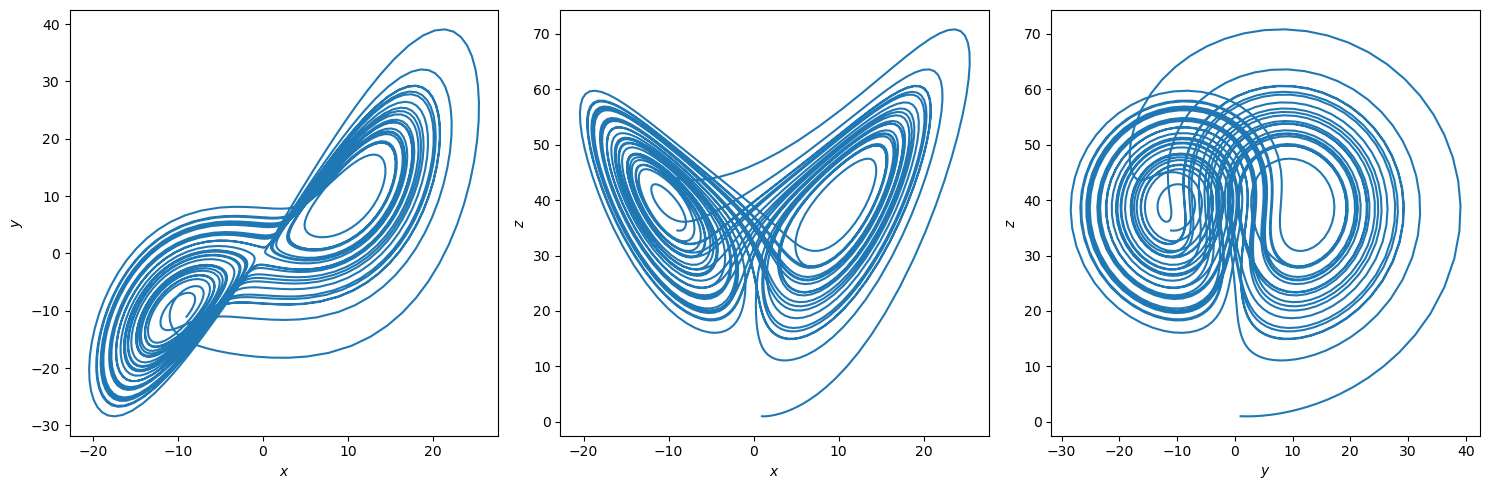

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# x-y
axes[0].plot(sol_state[0], sol_state[1])
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

# x-z
axes[1].plot(sol_state[0], sol_state[2])
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$z$")

# y-x
axes[2].plot(sol_state[1], sol_state[2])
axes[2].set_xlabel("$y$")
axes[2].set_ylabel("$z$")

plt.tight_layout()
plt.show()

### Divergent ODEs

Considering the following coupled ODEs that are divergent at $t\approx 1.209$,
\begin{align}
\frac{dx}{dt} &= x +y^2 \\
\frac{dy}{dy} &= x^2-y
\end{align}
with $(x_0,y_0)=(1,0)$ between $0\leq t\leq 3$. The alogrithm automatically stops around $t\approx 1.209$ and displays its warning message. This prevents `solve_ode` from indefinitely looping to find the unreachable solution.

In [8]:
# Divergent ODE at t = 1.209
def divergent_odes(t, z):
    x, y = z
    dx_dt = x + y**2
    dy_dt = x**2 - y
    return np.array([dx_dt, dy_dt])
t_span = (0,3)
z0 = [1,0]
div_sol_t,div_sol_z = solve_ode(divergent_odes,t_span,z0)

The solver has terminated at t = 1.209155955465455 due to too small step size. Suspect a divergence.

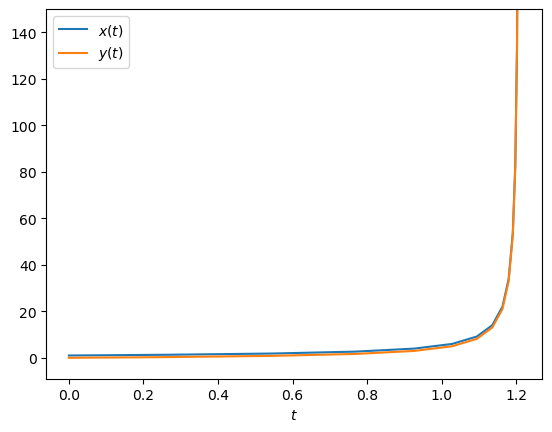

In [9]:
for i in range(2):
    plt.plot(div_sol_t,div_sol_z[i],label=labels[i])
plt.ylim(-9,150)
plt.legend()
plt.xlabel('$t$')
plt.show()

### Van der Pol oscillator

When a system is stiff, explicit method may not be sufficient to accurately find the solution. An implicit method should be introduced.
`solve_ode` automatically switches between explicit and implicit methods determined by the stiffness ratio $R$, which is derived from the system Jacobian. It can be turned on by setting `method="hybrid"` and the threshold $R_{\rm th}$ for which method should be used.

Considering the non-linear ODE system, the Van der Pol oscillator,
\begin{align}
\frac{dx}{dt} &= y \\
\frac{dy}{dt} &= \mu(t)(1-x^2)y - x + e^{-t}
\end{align}
where
$$
\mu(t)=\begin{cases}
1000, & 0\leq t<2,\\
1, & 2\leq t\leq10,
\end{cases}
$$
and $(x_0,y_0)=(2,0)$. It exihbits stiff and non-stiff features simutaneously depending on $\mu(t)$.

In [11]:
def van_der_pol(t, vars):
    x, y = vars
    # setupe mu(t)
    if t < 2:
        mu = 1000  # stiff
    else:
        mu = 1     # non-stiff
    # eqs
    dxdt = y
    dydt = mu * (1 - x**2) * y - x + np.exp(-t)
    return [dxdt, dydt]

# Initial condition
initial_conditions = [2.0, 0.0]
t_span = (0, 10) 
vdp_sol_t,vdp_sol_z = solve_ode(van_der_pol,t_span,initial_conditions,method='hybrid',atol=1e-5,rtol=1e-6,R_threshold=900)

Progress: 100.00% and stiffness ratio R = 1.629e+00.

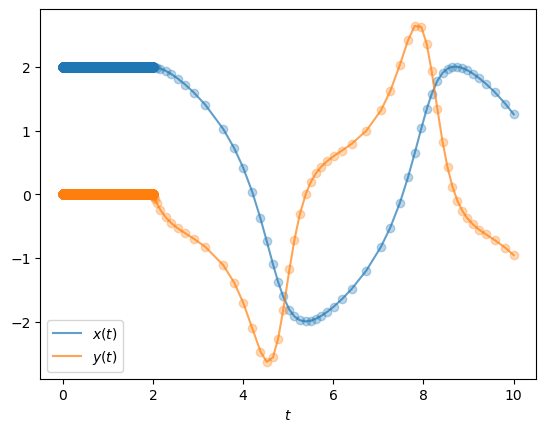

In [12]:
for i in range(2):
    plt.plot(vdp_sol_t,vdp_sol_z[i],label=labels[i],alpha=0.7)
    plt.scatter(vdp_sol_t,vdp_sol_z[i], alpha=0.3)
plt.legend()
plt.xlabel('$t$')

plt.show()

One can clearly see that when $t<2 $, the system is stiff and the solver automatically uses implicit method, which explains the large number of points accumulated for $t<2$. For later time, the system becomes non-stiff, the solver switches to explict method and accounts for the larger step size.